<a href="https://colab.research.google.com/github/kylelee417/Data-Science_Portfolio/blob/master/VAE%20V02%20updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


###Load required library

In [2]:
#dependencies (numpy, matplotlib, and keras)

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob #retriving an array of files in directories
from scipy.stats import norm
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, MaxPooling2D
from keras.layers import Lambda, Reshape, Activation, Dropout, SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.losses import binary_crossentropy, mse
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras import initializers
from keras.preprocessing.image import ImageDataGenerator



Using TensorFlow backend.


### Loading data

In [0]:
train_path ='/content/drive/My Drive/downloads/Data/Train'
test_path='/content/drive/My Drive/downloads/Data/Test'
new_path='/content/drive/My Drive/downloads/Data/New'

In [0]:
train_datagen = ImageDataGenerator(rescale=(1./255),
                                   validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

### Hyperparameters

In [0]:
img_width = 112
img_height = 112
img_channel = 1
input_shape = (img_height,img_width,img_channel)
batch_size = 32
latent_dim = 128
epochs = 300
learning_rate = 0.0001
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=10,verbose=1,factor=0.5,min_lr=0.00001)

In [6]:

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(img_width,img_height),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    class_mode=None, 
                                                    subset='training',  
                                                    shuffle=True,
                                                    seed=0)

valid_generator = train_datagen.flow_from_directory(train_path,
                                                    color_mode='grayscale',
                                                    target_size=(img_width,img_height),
                                                    batch_size=batch_size,
                                                    class_mode=None,
                                                    subset='validation', 
                                                    shuffle=True,
                                                    seed=0)

test_generator = test_datagen.flow_from_directory(test_path,
                                                  color_mode='grayscale',
                                                  target_size=(img_width,img_height),
                                                  batch_size=1,
                                                  shuffle=True,
                                                  seed=0)

new_generator = test_datagen.flow_from_directory(new_path,
                                                  color_mode='grayscale',
                                                  target_size=(img_width,img_height),
                                                  batch_size=1,
                                                  shuffle=False,
                                                  seed=0)



Found 422 images belonging to 2 classes.
Found 104 images belonging to 2 classes.
Found 158 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


###Building Variational Autoencoder

In [7]:
#source:https://medium.com/deeper-learning/glossary-of-deep-learning-batch-normalisation-8266dcd2fa82
#understanding the benefits of using batch normalization


#Encoding  - mapping image inputs to latent distribution parameters


input_img = Input(shape=(input_shape)) 

# Conv2d x 10 deep layers


x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
x = MaxPooling2D((2,2), name='pool1')(x)
    
x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
x = MaxPooling2D((2,2), name='pool2')(x)
    
x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
x = BatchNormalization(name='bn1')(x)
x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
x = BatchNormalization(name='bn2')(x)
x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
x = MaxPooling2D((2,2), name='pool3')(x)
    
x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
x = BatchNormalization(name='bn3')(x)
x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
x = BatchNormalization(name='bn4')(x)
x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
x = MaxPooling2D((2,2), name='pool4')(x)

encoded = Conv2D(latent_dim, (3,3), padding='same', name='Conv5')(x)

shape_before_flattening = K.int_shape(encoded)

encoded_to_z = Flatten()(encoded)



#Two outputs, latent mean and (log) variance
z_mean = Dense(latent_dim, name='z_mean')(encoded_to_z)
z_log_var = Dense(latent_dim, name='z_log_var')(encoded_to_z)


print(z_mean)
print(z_log_var)

W0902 21:12:50.906915 140253310678912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0902 21:12:50.944531 140253310678912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0902 21:12:50.950523 140253310678912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0902 21:12:50.982655 140253310678912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0902 21:12:51.047352 140253310678912 deprecation_wrapp

Tensor("z_mean/BiasAdd:0", shape=(?, 128), dtype=float32)
Tensor("z_log_var/BiasAdd:0", shape=(?, 128), dtype=float32)


In [8]:
# Using previous parameters to sample new similar points from the latent space

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(1,latent_dim), mean=0., stddev = 1.)
    return z_mean + K.exp(0.5*z_log_var) * epsilon     #log var(sigma) is used and exponentiated in case the network may learn negative values for sigma.

z = Lambda(sampling, output_shape=(latent_dim,), name='sampling')([z_mean, z_log_var])

#Encoder model 
encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')

print(z)
print(shape_before_flattening[1:])

Tensor("sampling/add:0", shape=(?, 128), dtype=float32)
(7, 7, 128)


In [9]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 112, 112, 1)  0                                            
__________________________________________________________________________________________________
Conv1_1 (Conv2D)                (None, 112, 112, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
Conv1_2 (Conv2D)                (None, 112, 112, 64) 36928       Conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 56, 56, 64)   0           Conv1_2[0][0]                    
____________________________________________________________________________________________

In [0]:

# decoder takes the latent distribution sample as input shape (None, 2)
decoder_input = Input(K.int_shape(z)[1:])

#Decoding part - mapping sampled latent points back to reconstructed inputs


#Expand to 6272 total pixels
x = Dense(6272, activation='relu')(decoder_input)

#Reshape (7*7*128)
x = Reshape(shape_before_flattening[1:])(x)


#Decoder
x = Conv2DTranspose(512, (2,2),padding='same', strides=(2,2))(x)
x = BatchNormalization(name='bn5')(x)
x = Activation('relu')(x)

x = Conv2DTranspose(256, (2,2),padding='same', strides=(2,2))(x)
x = BatchNormalization(name='bn6')(x)
x = Activation('relu')(x)

x = Conv2DTranspose(128, (2,2),padding='same', strides=(2,2))(x)
x = BatchNormalization(name='bn7')(x)
x = Activation('relu')(x)

x = Conv2DTranspose(64, (2,2),padding='same', strides=(2,2))(x)
x = BatchNormalization(name='bn8')(x)
x = Activation('relu')(x)

x = Conv2D(img_channel,(3,3), activation='sigmoid', padding='same')(x)

# decoder model statement
decoder = Model(decoder_input, x, name='decoder')

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(encoder(input_img)[2])


In [11]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              809088    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 512)       262656    
_________________________________________________________________
bn5 (BatchNormalization)     (None, 14, 14, 512)       2048      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 512)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 256)       5245

In [0]:
beta = 1 # 1 --> regular VAE
reconstruction_loss = mse(K.flatten(input_img), K.flatten(z_decoded))
# reconstruction_loss = binary_crossentropy(K.flatten(inputs),K.flatten(outputs))
reconstruction_loss *= img_height * img_width

kl_loss = -0.5*beta*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)

###Variational Autoencoder model

In [13]:
vae = Model(input_img, z_decoded)
vae.add_loss(vae_loss)
vae.compile(optimizer=Adam(lr=learning_rate,epsilon=10**-8))
vae.summary()

W0902 21:13:26.730167 140253310678912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 112, 112, 1)       0         
_________________________________________________________________
encoder (Model)              [(None, 128), (None, 128) 3104896   
_________________________________________________________________
decoder (Model)              (None, 112, 112, 1)       1764737   
Total params: 4,869,633
Trainable params: 4,864,641
Non-trainable params: 4,992
_________________________________________________________________


### Train VAE model

In [0]:
os.makedirs('best_weight_DCP_v1',exist_ok=True)
best_model_weight_path = os.path.join('best_weight_DCP_v1','dcp_v1'+'-best-wiehgts'+'-{epoch:03d}-{loss:.3f}-{val_loss:.3f}.h5')
save_best_model = ModelCheckpoint(best_model_weight_path,monitor='val_loss',verbose=0,save_weights_only=True,save_best_only=True,mode='min')

def fixed_generator(generator):
    for batch in generator:
        yield (batch,_)
def train_or_load_weights(flag,weight_name=None):
    if flag == 'train':
        hist = vae.fit_generator(fixed_generator(train_generator),
                         steps_per_epoch = train_generator.n//train_generator.batch_size,
                         epochs=epochs,
                         validation_data = fixed_generator(valid_generator),
                         validation_steps = valid_generator.n//valid_generator.batch_size,
                         verbose=1,
                         callbacks=[save_best_model,learning_rate_reduction,])#NEpochPrinter])
        return hist
    if flag == 'load':
        vae.load_weights(os.path.join('best_weight_DCP_v1',weight_name)) # load all the weights for encoder and decoder when loading for vae

In [15]:
hist = train_or_load_weights(flag='train')


Epoch 1/300
13/13 [==============================] - 125s 10s/step - loss: 1344.3882 - val_loss: 1237.6761
Epoch 2/300
13/13 [==============================] - 7s 505ms/step - loss: 1223.1756 - val_loss: 1137.4121
Epoch 3/300
13/13 [==============================] - 3s 238ms/step - loss: 1186.6786 - val_loss: 1237.9157
Epoch 4/300
13/13 [==============================] - 3s 241ms/step - loss: 1120.4054 - val_loss: 1120.2667
Epoch 5/300
13/13 [==============================] - 3s 244ms/step - loss: 1140.5030 - val_loss: 1105.4944
Epoch 6/300
13/13 [==============================] - 3s 241ms/step - loss: 1098.8415 - val_loss: 1435.8325
Epoch 7/300
13/13 [==============================] - 3s 243ms/step - loss: 935.9631 - val_loss: 1348.3544
Epoch 8/300
13/13 [==============================] - 3s 242ms/step - loss: 845.0963 - val_loss: 2037.4204
Epoch 9/300
13/13 [==============================] - 3s 248ms/step - loss: 741.8229 - val_loss: 2078.7475
Epoch 10/300
13/13 [====================

###Loss plots

In [0]:
def training_plot(hist,model_name):
    loss = [hist.history['loss'],hist.history['val_loss']]
    plt.plot(loss[0],color='b',label='training')
    plt.plot(loss[1],color='r',label='valid')
    plt.title(model_name,fontsize=18)
    plt.legend(loc='best',fontsize=13)
    plt.xlabel('epoch',fontsize=15)
    plt.ylabel('')
    plt.tick_params(axis='both',labelsize=13)

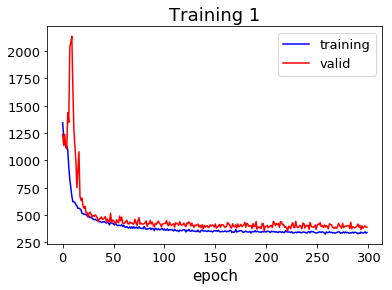

In [17]:
training_plot(hist, 'Training 1')

### New input prediction

In [18]:
new_input = vae.predict_generator(new_generator, steps=new_generator.samples, verbose=1)


4/4 [==============================] - 2s 445ms/step


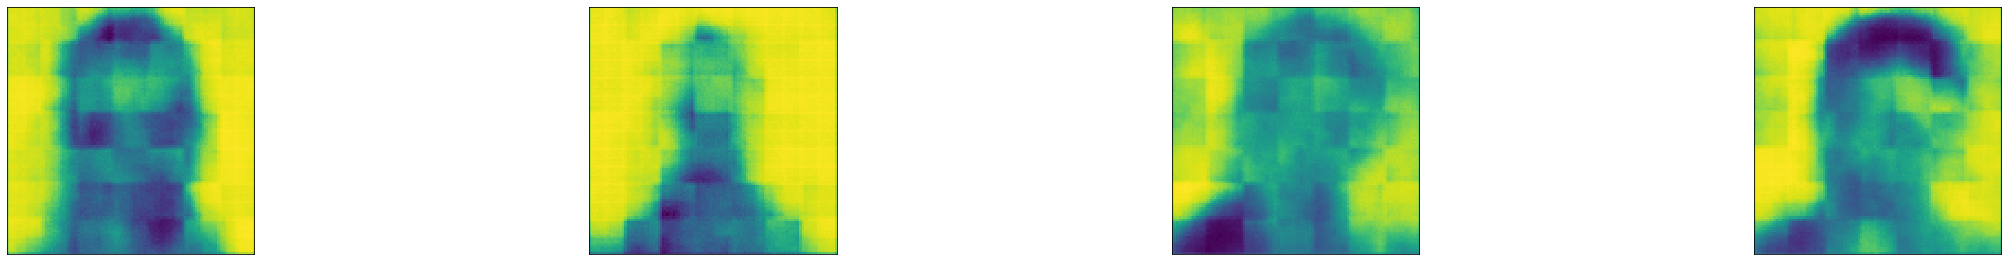

In [19]:
n = 4 # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # new input prediction
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(new_input[i].reshape(112,112))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [0]:
X_train = train_generator.next()



In [0]:
def plot_five_reconstruction(input_set,random_idx,encoder,decoder):
    fig, axes = plt.subplots(2,5,figsize=(15,5))
    for row,flag in zip(axes,['in_img','out_img']): 
        for col,idx in zip(row,random_idx):
            original = input_set[idx]
            if flag == 'in_img':
                original_img = original.reshape(img_height,img_width)
                col.imshow(original_img)
                col.set_title('original, idx={}'.format(idx))
            if flag == 'out_img':
                encoded_z = encoder.predict(np.expand_dims(original,0),batch_size=1)[2]
                predict = decoder.predict(encoded_z)
                decoded_img = predict.reshape(img_height,img_width)
                col.imshow(decoded_img)
                col.set_title('reconstructed, idx={}'.format(idx))
                           
            col.axis('off')

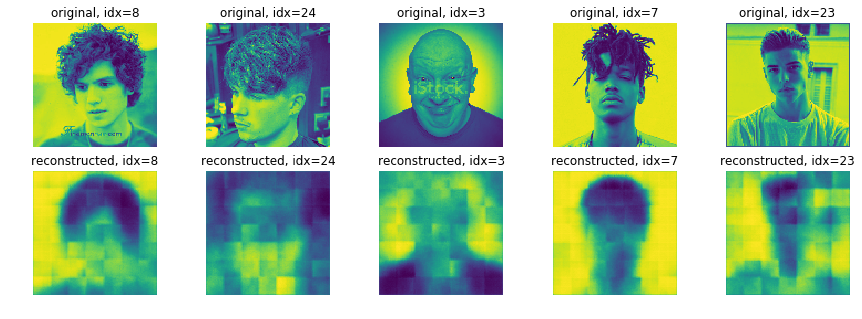

In [26]:
np.random.seed(100)
random_idx = np.random.randint(len(X_train),size=5)
plot_five_reconstruction(X_train,random_idx,encoder,decoder)